# Import Libraries

In [63]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential

pd.options.display.max_columns = None
pd.options.display.max_rows = None

# EDA

In [41]:
df = pd.read_csv("./data/KAGGLE/DATASET-balanced.csv")
df.sample(5)

,chroma_stft,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,LABEL
6311,0.419683,0.076881,1214.912716,1535.025535,2304.675081,0.037795,-316.796570,201.923065,-4.130780,4.403500,33.496933,-4.836303,-2.985745,2.830107,-22.308964,-17.826572,-4.272445,-9.329580,0.195427,9.126949,-1.052764,-3.599895,-0.298315,-0.320714,5.131833,3.034897,REAL
9818,0.293556,0.007978,2283.666833,3633.025039,4219.996676,0.033052,-513.674316,158.174561,-20.859081,29.045181,-3.078335,-15.899536,7.217334,-19.749342,-7.075452,-12.902023,0.324360,-5.305637,-4.142608,-5.001805,-9.006218,3.063140,6.088853,-11.923292,-3.432489,-1.121155,REAL
152,0.493318,0.051256,3073.480155,3225.984149,5519.719224,0.088306,-322.475922,140.481140,3.228429,35.295101,0.016650,11.099516,-16.543451,3.454555,-9.036996,1.953964,-7.251421,7.849971,-10.170651,0.597869,-4.661584,1.600701,-3.848318,0.065759,-1.484844,0.845690,FAKE
11066,0.295262,0.058382,1768.062499,2252.547332,2539.852061,0.043047,-327.246307,167.248550,-42.380013,-5.647784,-18.285988,11.615972,-5.447254,-18.314707,-11.890760,-14.603459,-7.758405,-12.764555,-4.897472,-7.114051,0.708552,0.069623,-11.358157,-10.425705,-6.732020,-7.773087,REAL
6751,0.380415,0.035209,1981.227506,2506.496960,3020.944149,0.047961,-363.416718,175.371735,-47.051380,-9.112650,-9.483279,8.867907,-9.456479,-13.540526,-7.959222,-16.292528,-2.741038,-5.720268,-3.257830,-2.361266,-2.404700,-4.033683,-7.446229,-5.988552,-2.338451,-9.315231,REAL


In [42]:
df.isna().sum()

chroma_stft           0
rms                   0
spectral_centroid     0
spectral_bandwidth    0
rolloff               0
zero_crossing_rate    0
mfcc1                 0
mfcc2                 0
mfcc3                 0
mfcc4                 0
mfcc5                 0
mfcc6                 0
mfcc7                 0
mfcc8                 0
mfcc9                 0
mfcc10                0
mfcc11                0
mfcc12                0
mfcc13                0
mfcc14                0
mfcc15                0
mfcc16                0
mfcc17                0
mfcc18                0
mfcc19                0
mfcc20                0
LABEL                 0
dtype: int64

In [43]:
df["LABEL"].value_counts()

LABEL
FAKE    5889
REAL    5889
Name: count, dtype: int64

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11778 entries, 0 to 11777
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   chroma_stft         11778 non-null  float64
 1   rms                 11778 non-null  float64
 2   spectral_centroid   11778 non-null  float64
 3   spectral_bandwidth  11778 non-null  float64
 4   rolloff             11778 non-null  float64
 5   zero_crossing_rate  11778 non-null  float64
 6   mfcc1               11778 non-null  float64
 7   mfcc2               11778 non-null  float64
 8   mfcc3               11778 non-null  float64
 9   mfcc4               11778 non-null  float64
 10  mfcc5               11778 non-null  float64
 11  mfcc6               11778 non-null  float64
 12  mfcc7               11778 non-null  float64
 13  mfcc8               11778 non-null  float64
 14  mfcc9               11778 non-null  float64
 15  mfcc10              11778 non-null  float64
 16  mfcc

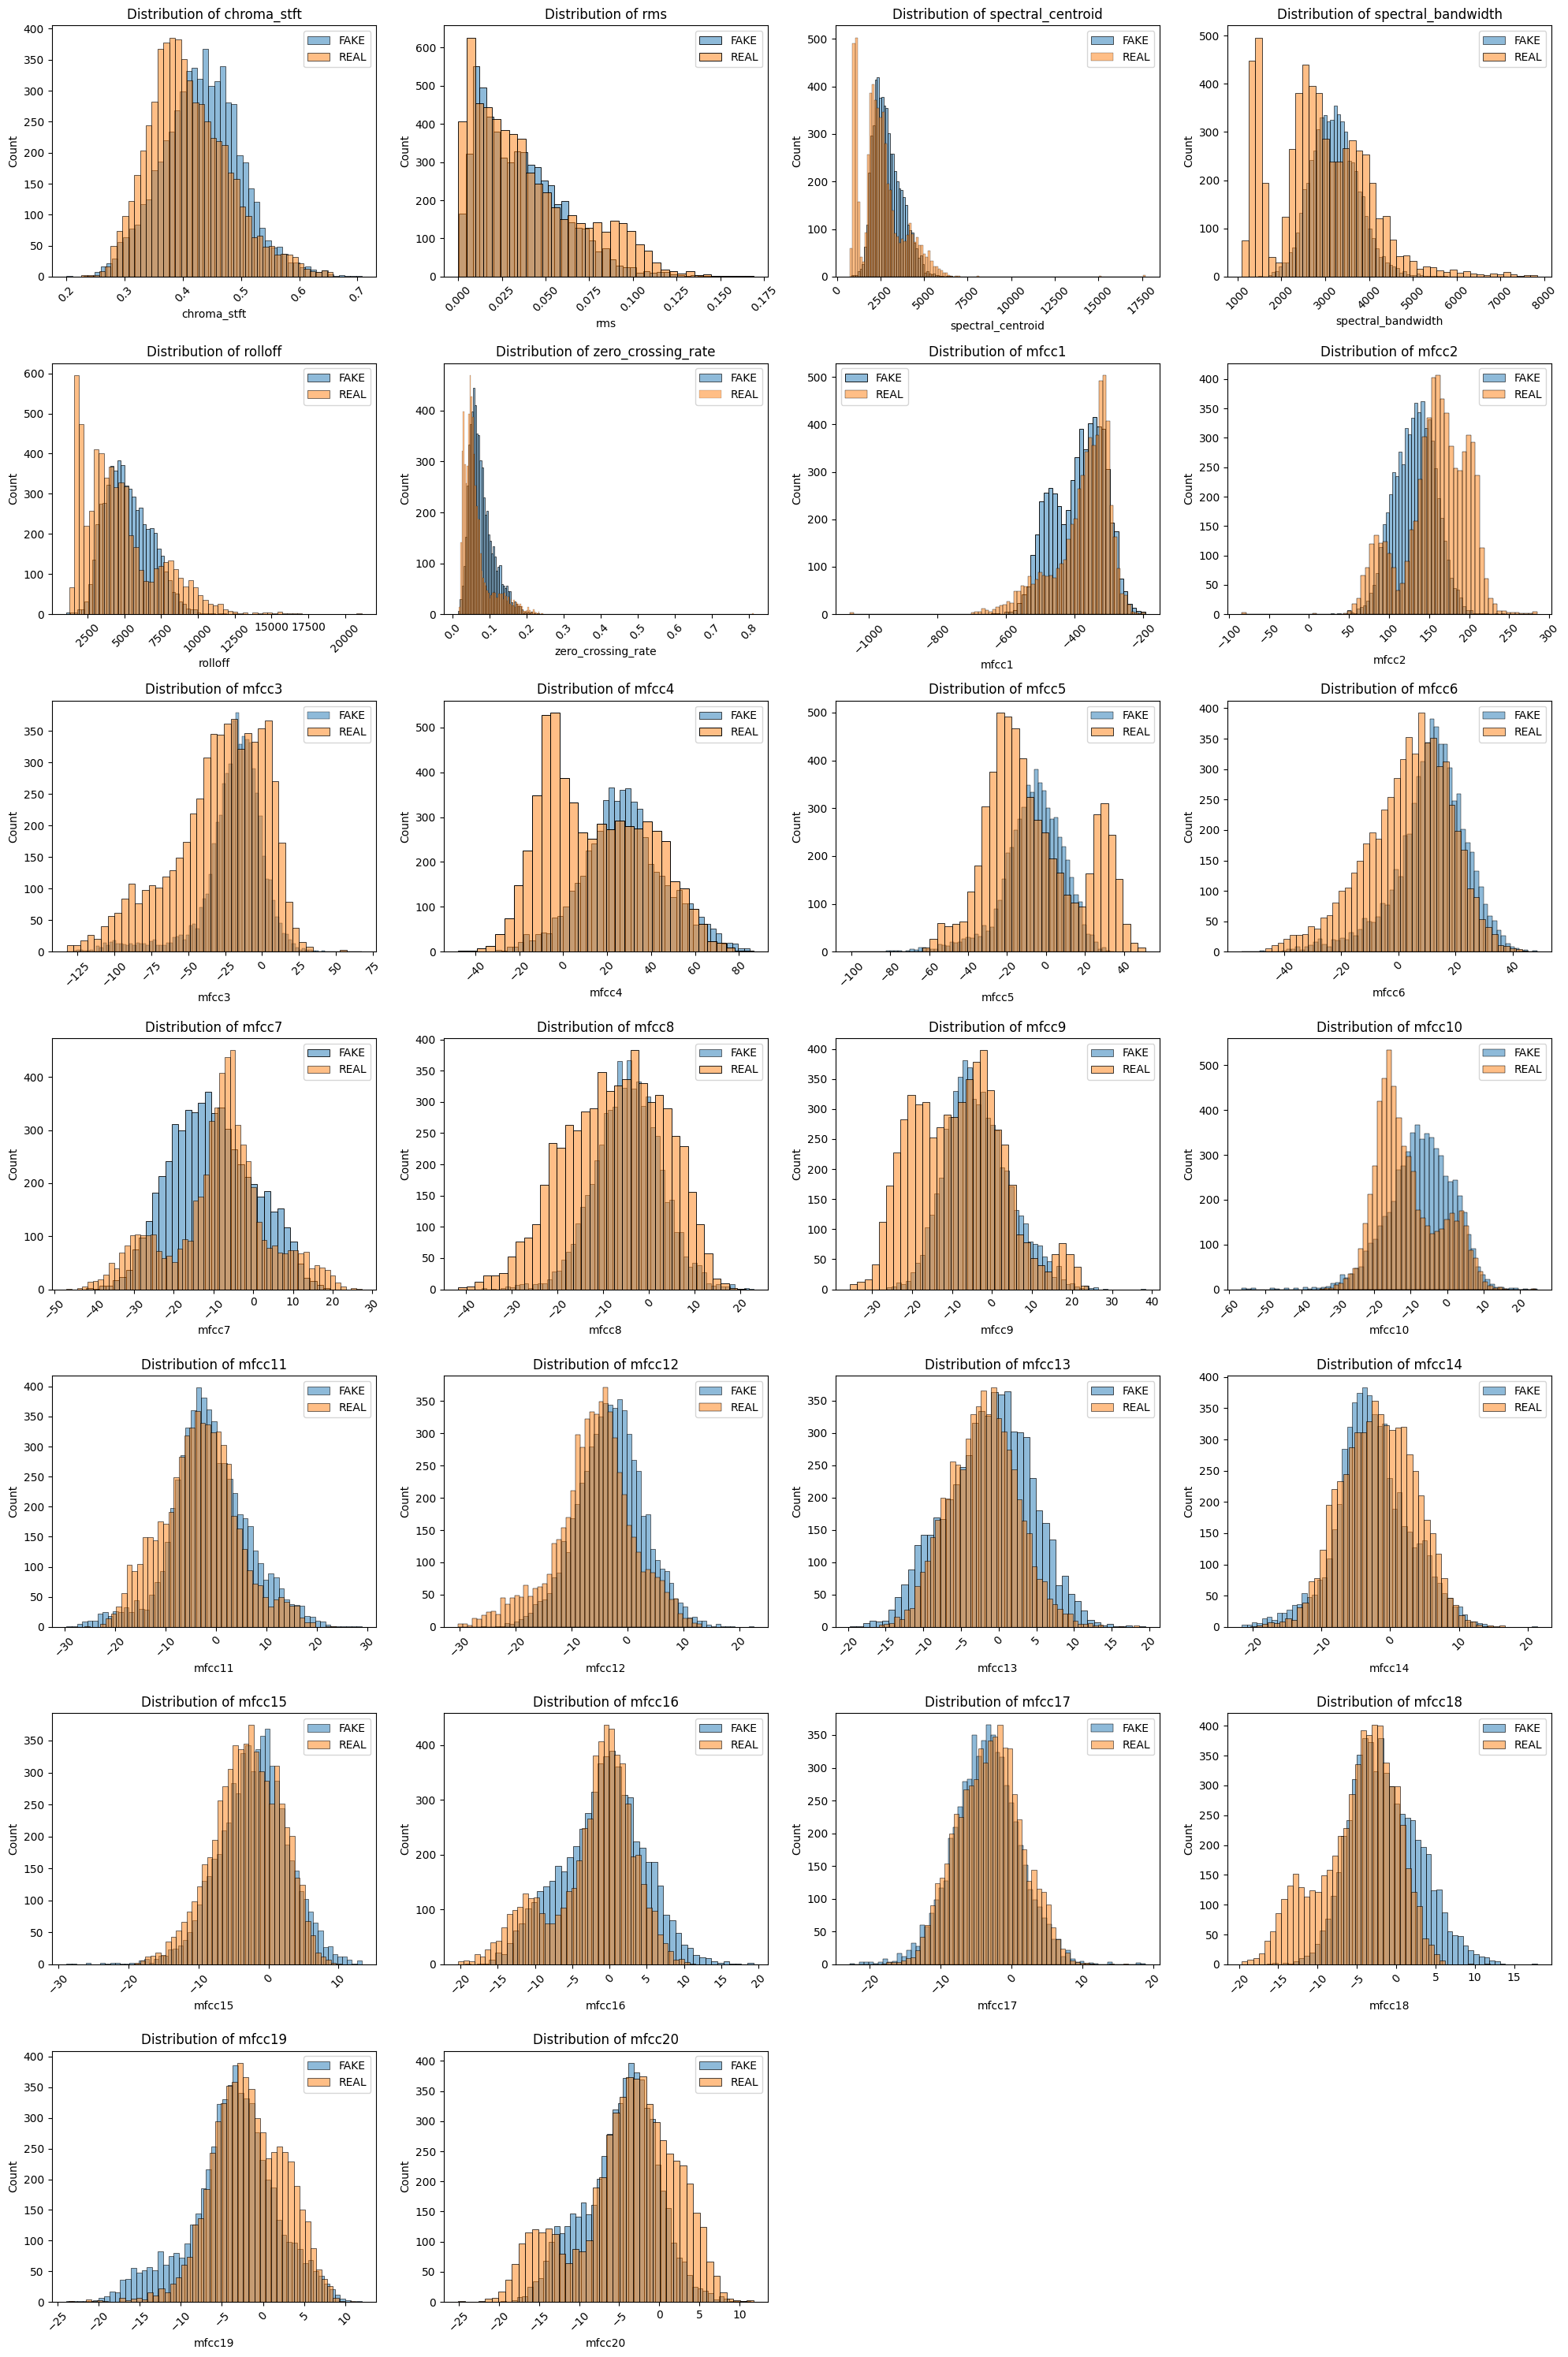

In [45]:
# Get columns
columns = df.select_dtypes(include=["float64"]).columns

# Create histogram plots for each numerical feature
plt.figure(figsize=(20, 30))
for i, col in enumerate(columns, 1):
    plt.subplot(7, 4, i)
    for label in df["LABEL"].unique():
        sns.histplot(data=df[df["LABEL"]==label], x=col, label=label, alpha=0.5)
    plt.title(f"Distribution of {col}")
    plt.legend()
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Preprocessing

In [61]:
X = df.drop(columns=["LABEL"])
y = df["LABEL"]

# Convert labels to binary
label_binarizer = preprocessing.LabelBinarizer()
label_binarizer.fit(y)
y = label_binarizer.transform(y)
y = y.ravel()

# Split the data into train and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(9422, 26)
(9422,)
(2356, 26)
(2356,)


# Random Forest

# Training

In [47]:
# Create Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform 5-fold cross-validation with hyperparameter tuning
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, n_jobs=-1)

start_time = time.time()
grid_search.fit(X_train, y_train)
end_time = time.time()

# Get the best parameters and best estimator
best_params = grid_search.best_params_
best_rf_classifier = grid_search.best_estimator_

print(f"Best parameters found: {best_params}")
print(f"Grid search elapsed time: {(end_time - start_time):.2f} seconds")

# Train the model on the full training set with the best parameters
start_time = time.time()
best_rf_classifier.fit(X_train, y_train)
end_time = time.time()

# Save the model to a file
joblib.dump(best_rf_classifier, "rf_model.joblib")

# Make predictions on test set
y_pred = best_rf_classifier.predict(X_test)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Print test set accuracy
print(f"\nTest set accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"Training elapsed time: {(end_time - start_time):.2f} seconds")

Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Grid search elapsed time: 228.99 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1178
           1       0.99      0.99      0.99      1178

    accuracy                           0.99      2356
   macro avg       0.99      0.99      0.99      2356
weighted avg       0.99      0.99      0.99      2356


Test set accuracy: 0.992
Training elapsed time: 5.06 seconds


## Evaluation

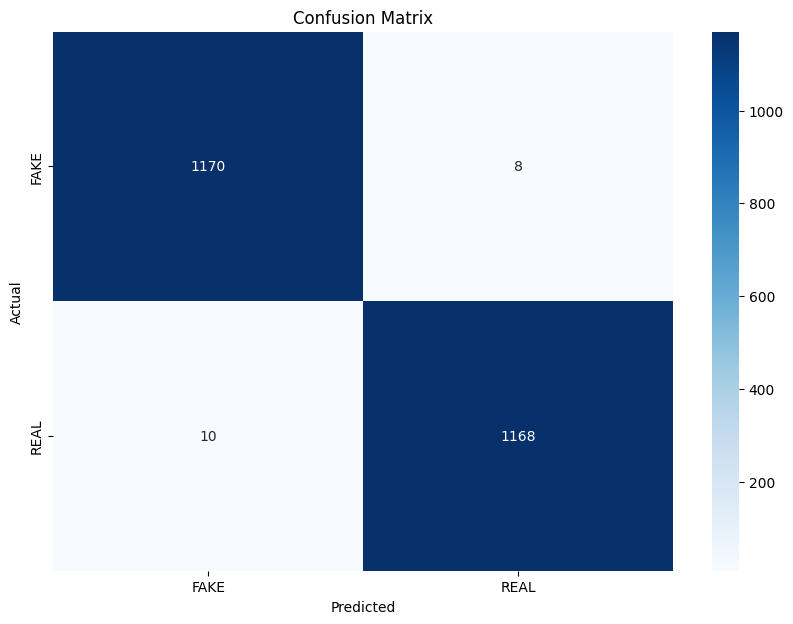

In [48]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_binarizer.classes_, yticklabels=label_binarizer.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# LSTM

## Reshape the Data

In [84]:
# Standardize the data
scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape the data for LSTM
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

print(X_train_reshaped.shape)
print(X_test_reshaped.shape)

(9422, 1, 26)
(2356, 1, 26)


## Training

In [86]:
model = Sequential()

input_shape = (X_train_reshaped.shape[1], X_train_reshaped.shape[2])
model.add(Input(shape=input_shape))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(32 , activation="relu"))
model.add(Dense(1, activation="sigmoid"))

optimizer = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=BinaryCrossentropy(), metrics=["accuracy"])
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_11 (LSTM)                  │ (None, 1, 64)          │        23,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,433 (228.25 KB)

 Trainable params: 58,433 (228.25 KB)

 Non-trainable params: 0 (0.00 B)

In [88]:
callbacks = [
    ModelCheckpoint(filepath="lstm_model.keras", monitor="val_accuracy", mode="max", save_best_only=True),
]

start_time = time.time()
history = model.fit(
    X_train_reshaped,
    y_train,
    batch_size=32,
    epochs=50,
    validation_data=(X_test_reshaped, y_test),
    callbacks=callbacks
)
end_time = time.time()

print(f"Training elapsed time: {(end_time - start_time):.2f} seconds")

Epoch 1/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9903 - loss: 0.0309 - val_accuracy: 0.9919 - val_loss: 0.0284
Epoch 2/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9931 - loss: 0.0253 - val_accuracy: 0.9941 - val_loss: 0.0211
Epoch 3/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9926 - loss: 0.0237 - val_accuracy: 0.9941 - val_loss: 0.0229
Epoch 4/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9919 - loss: 0.0218 - val_accuracy: 0.9932 - val_loss: 0.0261
Epoch 5/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9955 - loss: 0.0155 - val_accuracy: 0.9936 - val_loss: 0.0219
Epoch 6/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9956 - loss: 0.0135 - val_accuracy: 0.9962 - val_loss: 0.0187
Epoch 7/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9955 - loss: 0.0123 - val_accuracy: 0.9941 - val_loss: 0.0204
Epoch 8/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9939 - loss: 0.0181 - val_accu

## Evaluation

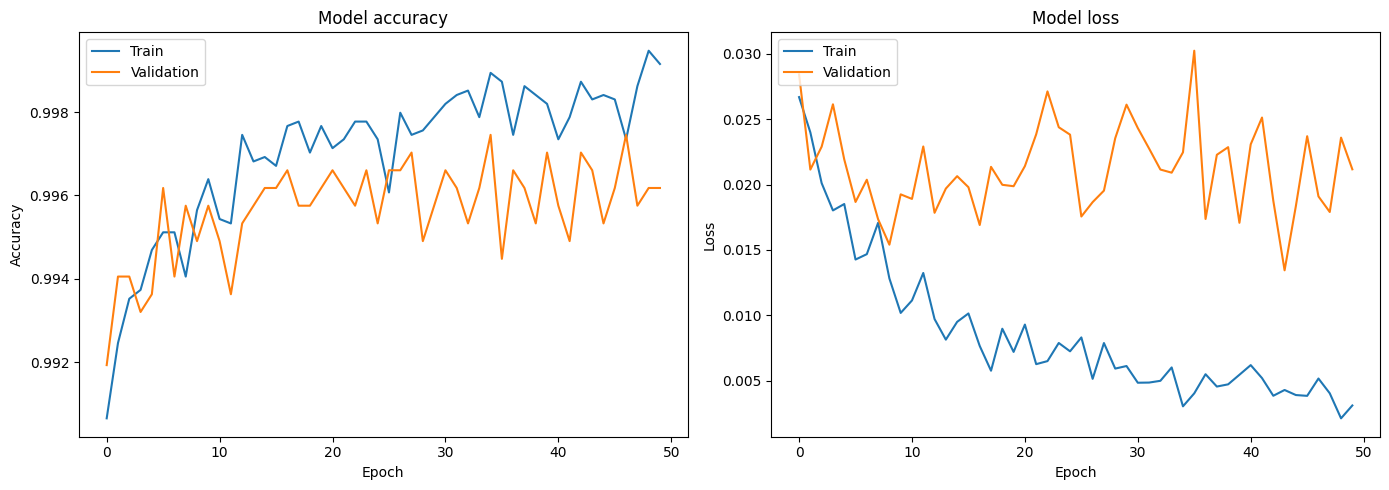

In [89]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")

plt.tight_layout()
plt.show()

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


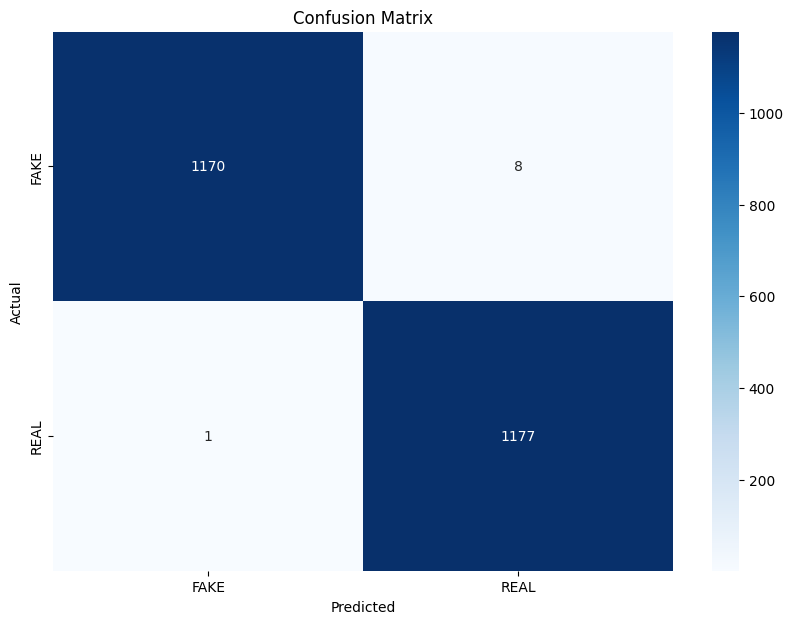

In [92]:
y_pred = (model.predict(X_test_reshaped) > 0.5).astype(int)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_binarizer.classes_, yticklabels=label_binarizer.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()